In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import importlib
from tqdm.auto import tqdm
matplotlib.rcParams['figure.figsize']=5,5
from time import sleep

# References

- [Climate Simulation Review](https://www.geo.uni-bremen.de/~apau/ecolmas_modeling2/mcguffie_henderson_sellers_2001.pdf)

- [Iceage Simulation 1973](https://journals.ametsoc.org/view/journals/apme/13/3/1520-0450_1974_013_0305_sotacu_2_0_co_2.xml?tab_body=pdf)

- [NCAR Circulation Model 1967](https://journals.ametsoc.org/view/journals/mwre/95/7/1520-0493_1967_095_0389_nggcmo_2_3_co_2.xml?tab_body=pdf)

- [GPU Gems 3 Fluid Simulation](https://developer.nvidia.com/gpugems/gpugems3/part-v-physics-simulation/chapter-30-real-time-simulation-and-rendering-3d-fluids)

- [Ceyron's Numpy Fluid Simulation Code](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/stable_fluids_python_simple.py)

- [Spherical Coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Integration_and_differentiation_in_spherical_coordinates)

- [Fluid Sphere](https://www.dropbox.com/s/excugsw43c9rxjd/spherical_fluid_PACM.pdf?dl=0)

- [Cloud Model](https://www.atmos.albany.edu/facstaff/rfovell/ATM562/soong-ogura-1973.pdf)


# Planar Flow

# Add Elevation

In [2]:
importlib.reload(importlib.import_module('fluid2D'))
import fluid2D

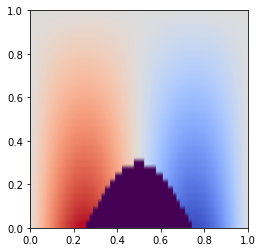

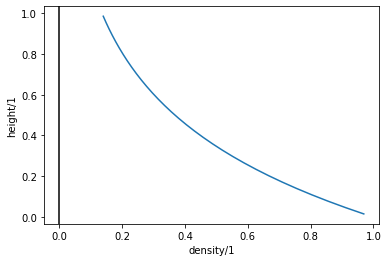

In [7]:
%matplotlib inline
fluid2D.gridRes=(128,32)
fluid2D.cellSizes=(1/128,1/32)
fluid2D.timeStep=0.01
from fluid2D import *

viscosity=.00
diffuse_T=.1
vorticity_eps=0

xy=get_positions()
x,y=xy[...,0],xy[...,1]
thetabar=np.ones_like(x)
rhobar=np.exp(-y/.5)
u0=np.zeros_like(xy)
theta0=thetabar+.5*np.sin(x*2*np.pi)*(1-y)
gravity=9.8
mask=y>-np.cos(x*2*np.pi)*.3

plt.ioff()

show_image(theta0,cmap='coolwarm',vmin=.5,vmax=1.5)
show_image(0,mask=mask,alpha=1)
plt.show()

plt.plot(rhobar[0],y[0])
plt.axvline(0,color='black')
plt.ylabel('height/1')
plt.xlabel('density/1')
plt.show()


<IPython.core.display.Javascript object>


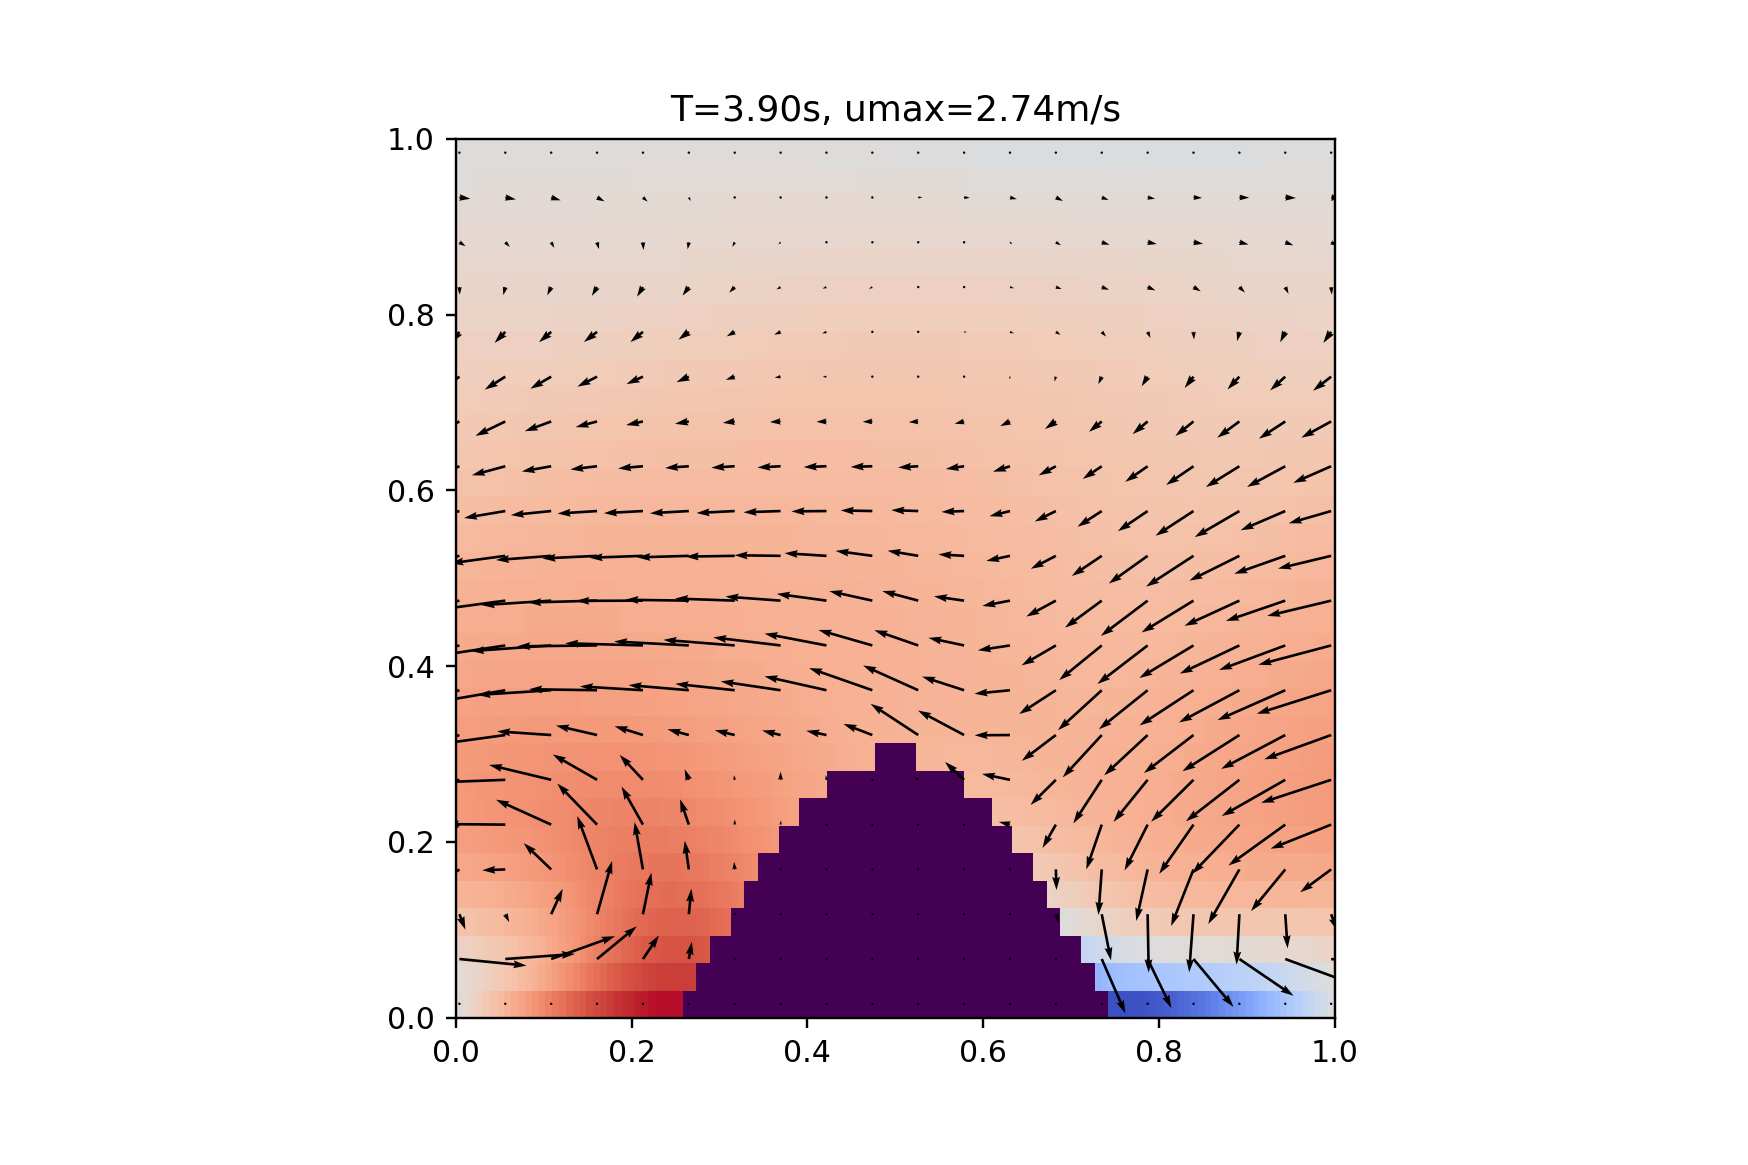

  0%|          | 0/400 [00:00<?, ?it/s]

In [9]:
%matplotlib notebook



#u=laminar_flow()
#u+=diffused_noise(u.shape,diffuse_amount=.001,nIter=1000)*.1

u=u0.copy()
theta=theta0.copy()
time=0
_,p=solve_pressure(u,1,nIter=40,old_pressure=None)
_,w=amplify_vorticity(u,vorticity_eps)

fig=plt.figure(figsize=(6,4), dpi=160)
plt.ion()
def show():
    plt.clf()
    show_image(theta,cmap='coolwarm',vmin=.5,vmax=1.5)
    show_image(0,mask=mask,alpha=1)
    show_quiver(xy,u,scale=20,numbers=[20,20])
    umax=np.max(u,axis=None)
    plt.title(f'T={time:.2f}s, umax={umax:.2f}m/s')
    fig.canvas.draw()

for _iter in tqdm(range(400)):
    if _iter%10==0:
        show()

    u=add_buoyancy(u,acceleration=gravity*(theta/thetabar-1))

    theta=advect(theta,u)
    u=advect_velocity_MacCormack(u)

    theta=diffuse(theta,amount=diffuse_T*timeStep,nIter=20)
    u=diffuse(u,amount=viscosity*timeStep,nIter=20)


    u,w=amplify_vorticity(u,vorticity_eps)

    u,p=solve_pressure(u,density=rhobar,nIter=40,old_pressure=p)

    u=apply_dirichlet_boundary_(u,u0)
    u=np.where(mask[...,None],u,u0)
    theta=apply_dirichlet_boundary_(theta,theta0)
    time=time+timeStep
plt.show()


# Atmospheric Model and Water Transportation

In [2]:
importlib.reload(importlib.import_module('fluid2D'))
from fluid2D import *
importlib.reload(importlib.import_module('cloudModel'))
from cloudModel import *

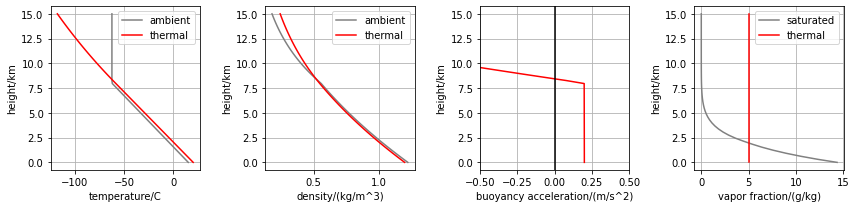

In [3]:
%matplotlib inline

desc=Atmosphere_Model_Desc(L0=0.00968)

heights=np.linspace(0,15000)
pbar,rhobar,Tbar=atmosphere_model(heights,desc=desc)
show_buoyancy_analysis(heights=heights,T0=15+5+273.15,Qv0=0.005,Tbar=Tbar,pbar=pbar)

In [175]:

    

import fluid2D
fluid2D.gridRes=(256,96)
fluid2D.cellSizes=(8000/64,8000/64)
fluid2D.timeStep=1
from fluid2D import *
from cloudModel import *

viscosity=1
diffuse_T=1
vorticity_eps=0

xy=get_positions()
x,y=xy[...,0],xy[...,1]
xyn=get_normalized_positions()
xn,yn=xyn[...,0],xyn[...,1]

mask=y>np.clip(-np.cos(xn*2*np.pi),0,1)*(.5+.5*+np.cos(8*xn*2*np.pi))*2000

pbar,rhobar,Tbar=atmosphere_model(y,desc=desc)
thetabar=get_potential_temperature(Tbar,pbar)

time=0

u_bc=np.zeros_like(xy)
u=u_bc.copy()

theta_bc=thetabar.copy()
theta_bc+=5*np.sin(xn*2*np.pi)*np.exp(-y/1000)
theta=theta_bc.copy()

_,p=solve_pressure(u,density=rhobar,nIter=40,old_pressure=None)

Qv_bc=np.zeros_like(Qv)
Qv=0.005*np.exp(-y/2000)
Qc=np.zeros_like(Qv)
Qr=np.zeros_like(Qv)



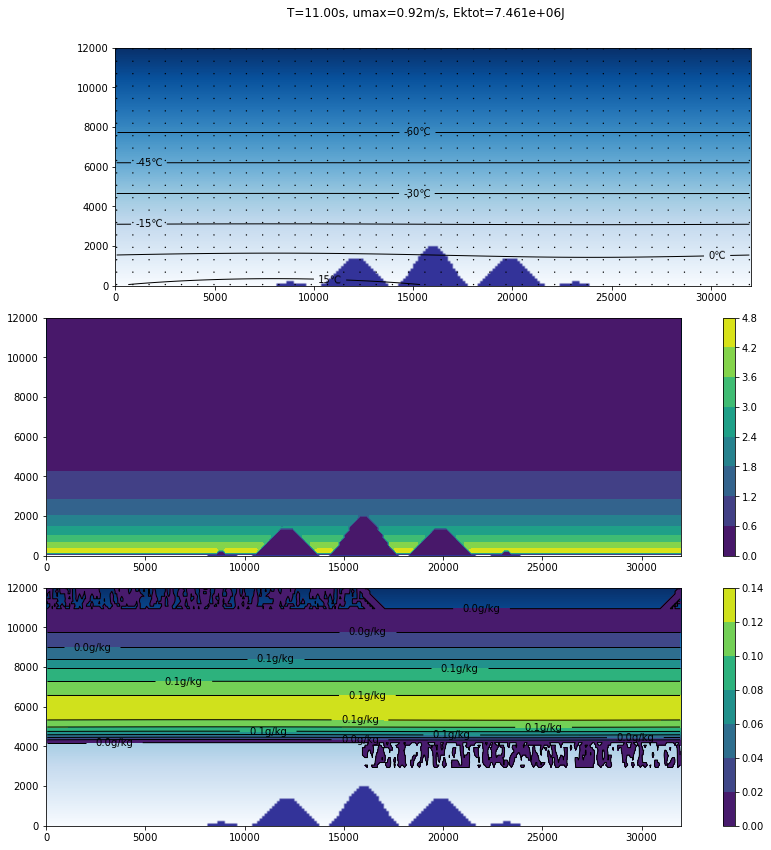

In [184]:
%matplotlib inline

def draw():
    
    plt.subplot(311)
    show_image(y,cmap='Blues')
    show_image(0,mask=mask,cmap='terrain')
    #Temperature
    contour=plt.contour(x,y,get_temperature(theta,pbar)-273.15,colors='black',linestyles='solid',linewidths=1,vmin=-50,vmax=50)
    plt.gca().clabel(contour, contour.levels,fmt=lambda x:f'{x:.0f}℃')
    #wind
    show_quiver(xy,u,scale=500,numbers=[40,20])
    
    plt.subplot(312)
    show_image(y,cmap='Blues')
    show_image(0,mask=mask,cmap='terrain')
    #Qv
    plt.contourf(x,y,Qv*1000,cmap='viridis')
    plt.colorbar()
#     contour=plt.contour(x,y,Qv*1000,colors='black',linestyles='dashed',linewidths=1)
#     plt.gca().clabel(contour, contour.levels,fmt=lambda x:f'{x:.1f}g/kg')
    
    plt.subplot(313)
    show_image(y,cmap='Blues')
    show_image(0,mask=mask,cmap='terrain')
    #Qc
    plt.contourf(x,y,Qc*1000,cmap='viridis')
    plt.colorbar()
    contour=plt.contour(x,y,Qc*1000,colors='black',linestyles='solid',linewidths=1)
    plt.gca().clabel(contour, contour.levels,fmt=lambda x:f'{x:.1f}g/kg')
    
    #captions
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    umax=np.max(u,axis=None)
    Ek=calc_total_kinematic_energy(u,rhobar)
    plt.suptitle(f'T={time:.2f}s, umax={umax:.2f}m/s, Ektot={Ek:.3e}J')
    
plt.figure(figsize=(12,12))
draw()
plt.show()

<IPython.core.display.Javascript object>


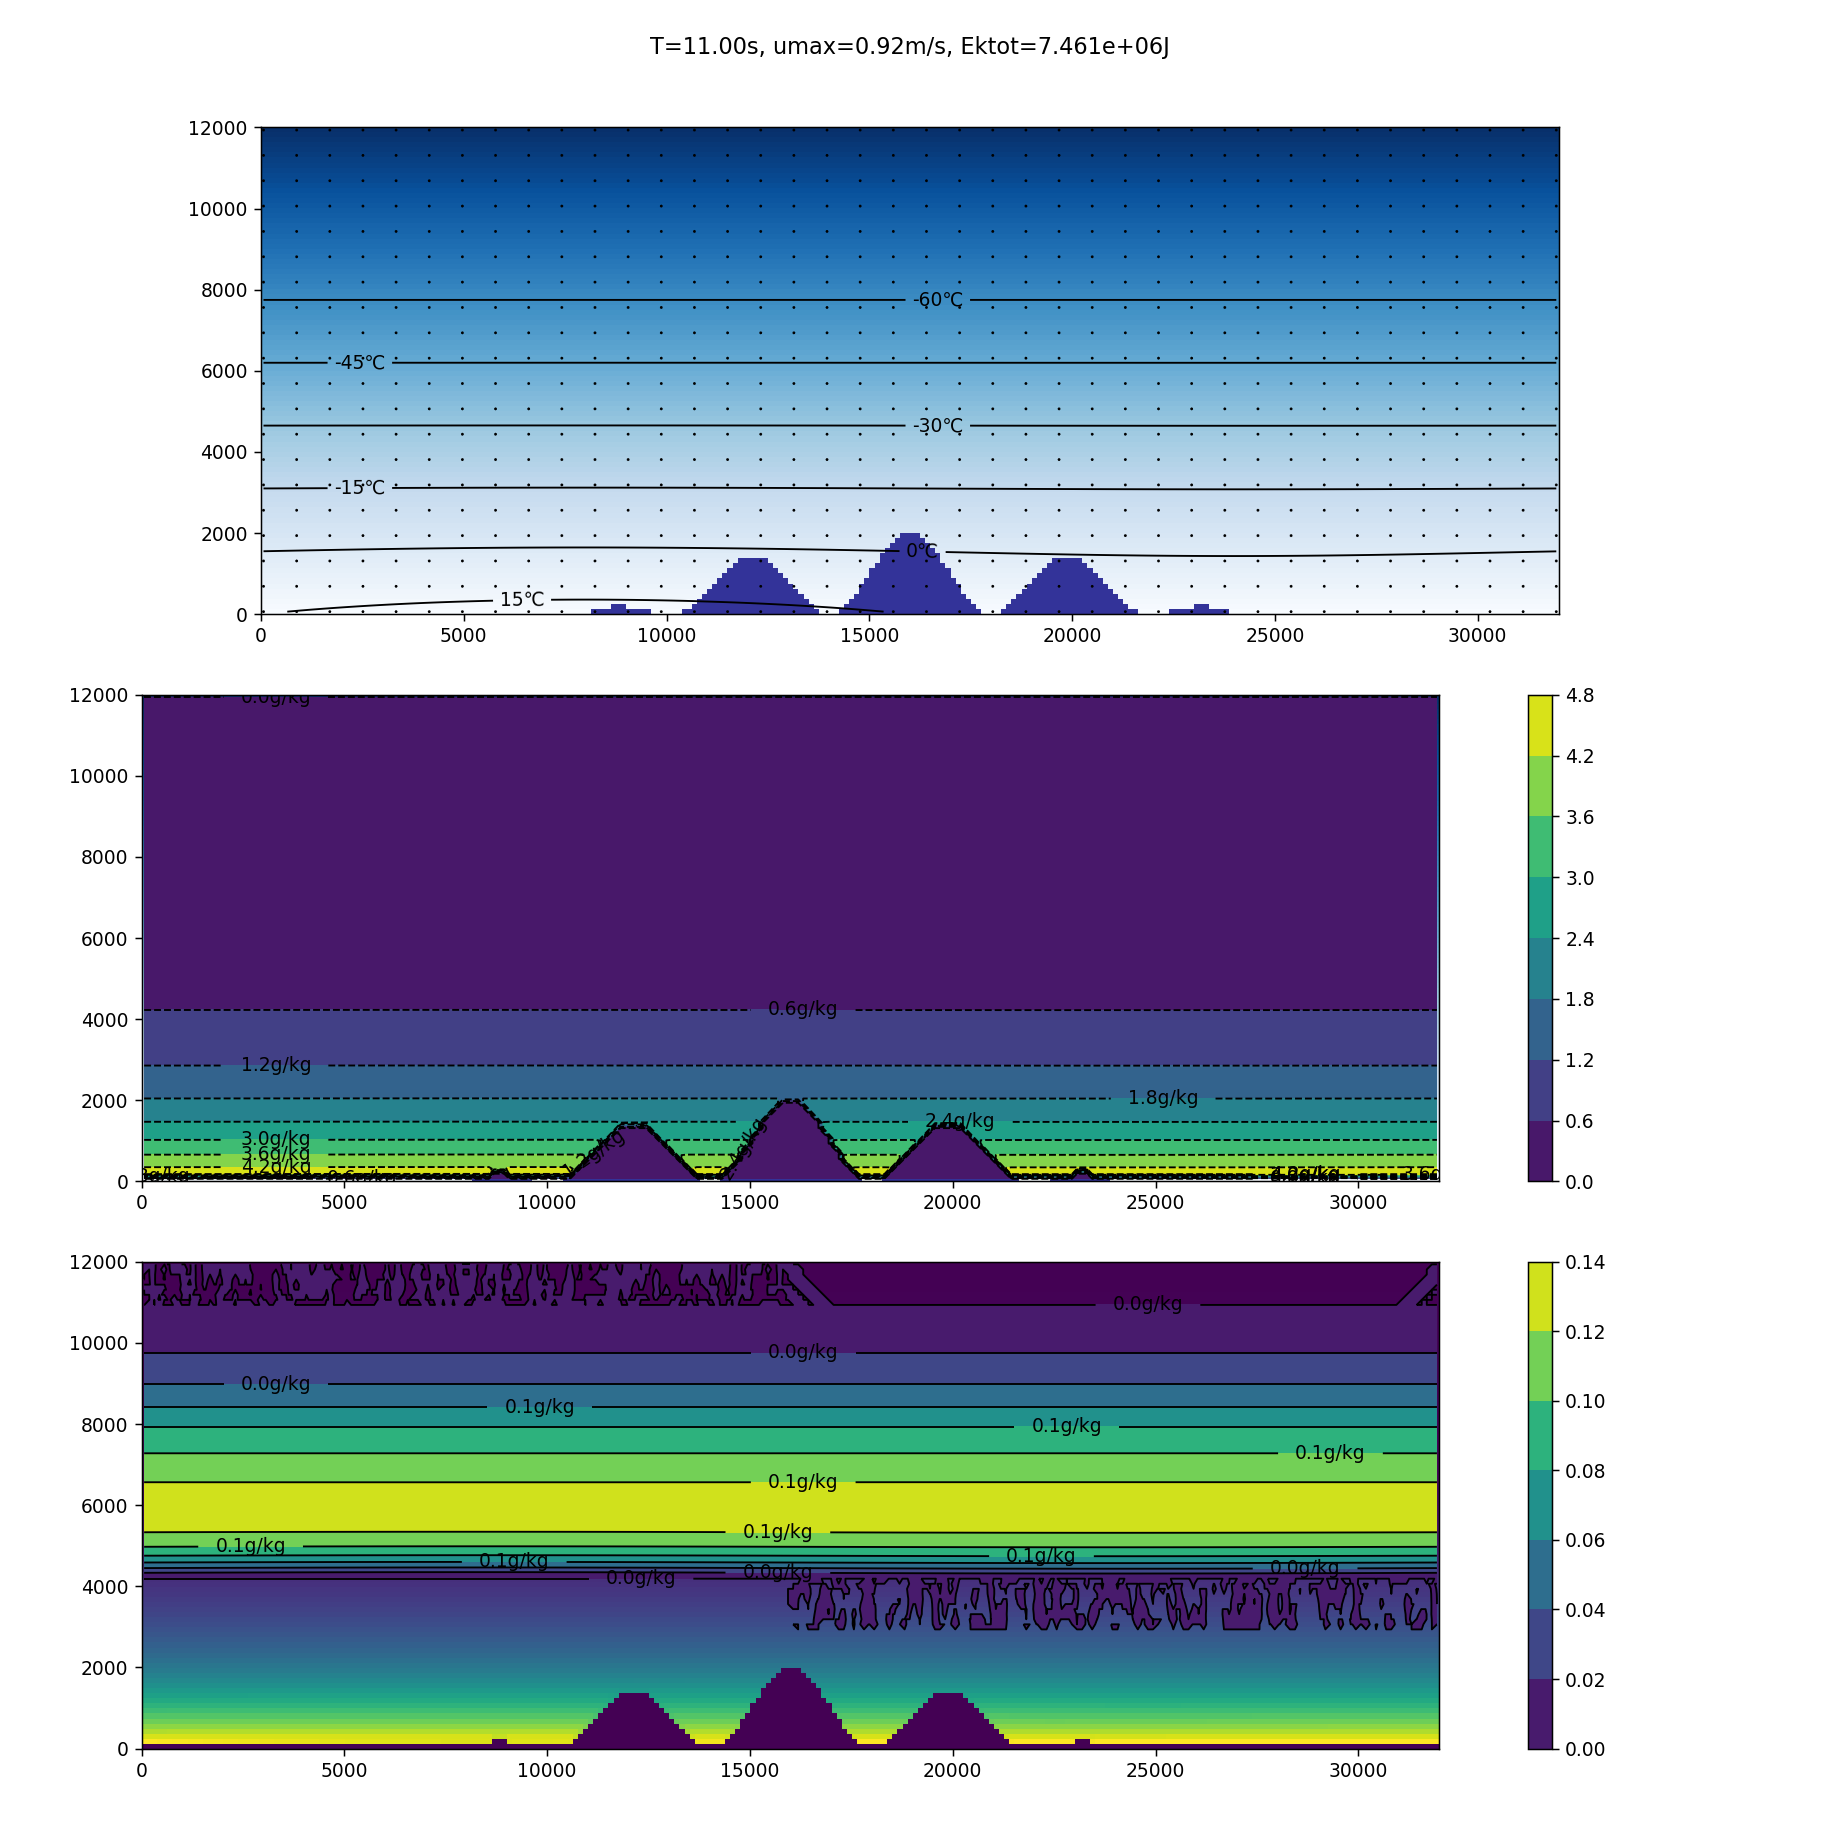

  0%|          | 0/14400 [00:00<?, ?it/s]

/tmp/ipykernel_3695247/1689416740.py:29: UserWarning: No contour levels were found within the data range.
  contour=plt.contour(x,y,Qc*1000,colors='black',linestyles='solid',linewidths=1)


KeyboardInterrupt: 

In [177]:
%matplotlib notebook

fig=plt.figure(figsize=(10,10),dpi=100)
plt.ion()
def update_graph():
    plt.clf()
    draw()
    fig.canvas.draw()

    
for _iter in tqdm(range(int(4*3600/timeStep))):
    if _iter%1==0:
        update_graph()
        sleep(1)
    
    B=get_buoyancy_acceleration(T_ratio=theta/thetabar)
    u=add_buoyancy(u,acceleration=B)
    
    theta=advect(theta,u)
    Qv=advect(Qv,u)
    Qc=advect(Qc,u)
    Qr=advect(Qr,u)
    u=advect_velocity_MacCormack(u)
    

    theta=diffuse(theta,amount=diffuse_T*timeStep,nIter=20)
    u=diffuse(u,amount=viscosity*timeStep,nIter=20)
    
    theta,Qv,Qc,Qr=update_cloud_model(theta,Qv,Qc,Qr,pbar=pbar,timeStep=timeStep)

    u,w=amplify_vorticity(u,vorticity_eps)

    u,p=solve_pressure(u,density=rhobar,nIter=40,old_pressure=p)
    
    def apply_boundary_(x,x_bc):
        shape=x.shape
        x=x.reshape(shape[:2]+(-1,))
        x_bc=x_bc.reshape(shape[:2]+(-1,))
        x=np.where(mask[...,None],x,x_bc)
        return apply_dirichlet_boundary_(x,x_bc).reshape(shape)
    
    u=apply_boundary_(u,u_bc)
    theta=apply_boundary_(theta,theta_bc)
    Qv=apply_boundary_(Qv,Qv_bc)
    
#     u=apply_dirichlet_boundary_(u,u_bc)
#     u=np.where(mask[...,None],u,u_bc)
#     theta=apply_dirichlet_boundary_(theta,theta_bc)
    time=time+timeStep
    
plt.show()


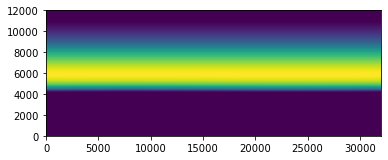

In [181]:
%matplotlib inline
show_image(Qc)

# TODO

add friction

vorticity eps has bug!

rain falling

rain friction


# Spherical Flow

In [58]:
import math
math.prod(T.shape[2:])

1

# 3D Spherical Flow

# Radiance Effect

# Ocean current

# Glacier

# Biomes